![Imagen de WhatsApp 2024-12-10 a las 13.54.23_70589078.jpg](<attachment:Imagen de WhatsApp 2024-12-10 a las 13.54.23_70589078.jpg>)
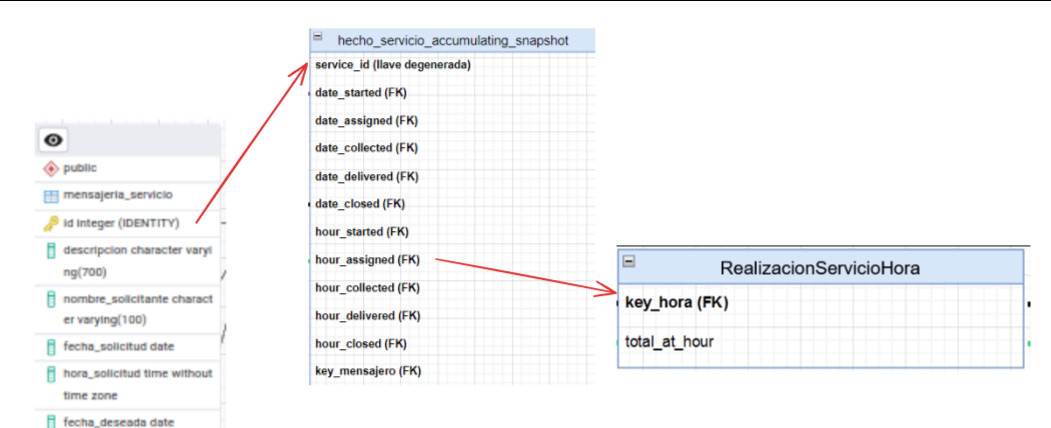

## Importar librerías

In [ ]:
import pandas as pd
import sqlalchemy as sa
import utils.conn_tools as ct

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

### Asimilación de dimensiones

In [ ]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

## Extract

In [ ]:
# Leer los datos de las tablas

# De la fuente
msj_servicio = pd.read_sql_table("mensajeria_servicio", con=engine_src)

# Del Warehouse
hecho_servicio_accumulating_snapshot = pd.read_sql_table(
    "hecho_servicio_accumulating_snapshot", con=engine_etl
)

## Transform

In [ ]:
# Crear DataFrame con los datos de servicios (solo necesarios)
merged_df = pd.DataFrame(
    {
        "servicio_id": msj_servicio["id"],
    }
)

# Combinar con dim_hora para obtener las horas
merged_df = merged_df.merge(
    hecho_servicio_accumulating_snapshot,
    left_on="servicio_id",
    right_on="service_id",
    suffixes=("_mdf", "_hecho"),
)

# Limpiar para quedarse unicamente con la hora deseada
merged_df = pd.DataFrame(
    {
        "key_hora": merged_df["time_assigned"],
    }
)

merged_df.head(3)

In [ ]:
# Limpiar para quedarse unicamente con la key_mensajero
merged_df = pd.DataFrame(
    {
        "key_hora": merged_df["key_hora"],
    }
)

print(f"Cantidad de filas después de la limpieza: {merged_df.shape[0]}")
merged_df.head(10)

In [ ]:
# Limpiar para quedarse unicamente con el key_cliente
merged_df = pd.DataFrame(
    {
        "key_hora": merged_df["key_hora"],
    }
)

print(f"Cantidad de filas después de la limpieza: {merged_df.shape[0]}")
merged_df.head(3)

In [ ]:
# Extraer solo datos necesarios
merged_df = pd.DataFrame(
    {
        "key_hora": merged_df["key_hora"],
    }
)

print(merged_df.count())
merged_df.head(3)

In [ ]:
# Group
merged_df = merged_df.groupby(
    ["key_hora"]
).size().reset_index(name="total_at_hour")

## Load: Ejecución de ETL

In [ ]:
hecho_realizacion_servicio_hora_table = sa.Table(
    "hecho_realizacion_servicio_hora",
    metadata,
    # Primary key
    sa.Column(
        "key_hecho_realizacion_servicio_hora",
        sa.Integer,
        primary_key=True,
        autoincrement=True,
    ),
    # Dimension keys
    sa.Column("key_hora", sa.Integer, sa.ForeignKey("dim_hora.key_hora")),
    sa.Column("total_at_hour", sa.Integer),
)

metadata.create_all(engine_etl)

In [ ]:
merged_df.to_sql(
    name="hecho_realizacion_servicio_hora",
    con=engine_etl,
    if_exists="append",
    index=False,
)